In [15]:
import yfinance as yf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum

In [16]:
# Initialize Spark session
spark = SparkSession.builder.appName("InsiderTradeAnalysis").getOrCreate()

# Load patent dataset into a PySpark DataFrame
insider_df = spark.read.csv("data/insider-trading-recent.csv", header=True, inferSchema=True)

# Analyze the Impact of Insider Trading on a Stock

### 1. Find the top 5 tickers with the most buy and sell activity:

In [37]:
# Filter the DataFrame to only include "Sale", "S", "Purchase", and "P" transaction codes
filtered_df = insider_df.filter(col("TransactionCode").isin(["Sale", "S", "Purchase", "P"]))

# Group by the Ticker and TransactionCode columns and count the occurrences
grouped_df = filtered_df.groupBy("Ticker", "TransactionCode").count()

# Transform the grouped DataFrame to have the counts of sales and purchases for each ticker
activity_df = grouped_df.groupBy("Ticker") \
    .agg(
        sum(when(col("TransactionCode").isin(["Sale", "S"]), col("count")).otherwise(0)).alias("TotalSales"),
        sum(when(col("TransactionCode").isin(["Purchase", "P"]), col("count")).otherwise(0)).alias("TotalPurchases")
    ) \
    .withColumn("TotalActivity", col("TotalSales") + col("TotalPurchases"))
    
# Filter the activity DataFrame to only include tickers with at least 10 purchases and 10 sales
filtered_activity_df = activity_df.filter((col("TotalSales") >= 10) & (col("TotalPurchases") >= 10))

# Get the top 5 tickers with the highest total activity among those with at least 1 purchase and 1 sale
top5_active_tickers = filtered_activity_df.orderBy(col("TotalActivity").desc()).take(5)

if top5_active_tickers:
    print("Top 5 tickers with the highest activity (with at least 1 sale and 1 purchase) are:")
    for ticker in top5_active_tickers:
        print(f"Ticker: {ticker['Ticker']}")
        print(f"Total Sales: {ticker['TotalSales']}")
        print(f"Total Purchases: {ticker['TotalPurchases']}")
        print(f"Total Activity: {ticker['TotalActivity']}")
        print("-" * 50)
else:
    print("No tickers found with at least 1 sale and 1 purchase.")


Top 5 tickers with the highest activity (with at least 1 sale and 1 purchase) are:
Ticker: BRT
Total Sales: 374
Total Purchases: 911
Total Activity: 1285
--------------------------------------------------
Ticker: ASAN
Total Sales: 122
Total Purchases: 346
Total Activity: 468
--------------------------------------------------
Ticker: HUBS
Total Sales: 303
Total Purchases: 13
Total Activity: 316
--------------------------------------------------
Ticker: AKAM
Total Sales: 59
Total Purchases: 121
Total Activity: 180
--------------------------------------------------
Ticker: DOCU
Total Sales: 164
Total Purchases: 14
Total Activity: 178
--------------------------------------------------


### 2. Define function to split ticker data and fetch historical stock price data:

In [33]:
def get_data(ticker: str, start_date: str = None, end_date: str = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    :param ticker: The stock's trading symbol (i.e. AAPL)
    :param start_date: The start date for the data (formatted as %Y-%m-%d)
    :param end_date: The end date for the data (formatted as %Y-%m-%d)
    
    NOTE: If start_date and end_date are none, the largest available timeframe from the insider trading data will be used.
    
    :return tuple: 
        - pd.DataFrame: The filtered insider trading data for the given ticker
        - pd.DataFrame: The historical price data from yahoo finance API for the given ticker in the given timeframe
    """
    # Get all available tickers in the insider trading analysis dataset:
    unique_tickers = insider_df.toPandas()["Ticker"].unique()
    assert ticker in unique_tickers, f"{ticker} is not available"
    
    # Filter the grouped DataFrame to only include rows with the ticker in the TICKER variable
    # The filter that has been applied has just removed all transaction codes besides sell and buy
    ticker_df = filtered_df.filter(col("Ticker") == ticker)
    
    # Use yfinance to fetch the historical stock data for the given date range
    if start_date is None:
        start_date = ticker_df.agg({"TransactionDate": "min"}).collect()[0]["min(TransactionDate)"]
    if end_date is None:
        end_date = ticker_df.agg({"TransactionDate": "max"}).collect()[0]["max(TransactionDate)"]
    hist_df = yf.Ticker(ticker).history(start=start_date, end=end_date)
    
    return ticker_df, hist_df


### 3. Define a function to visualize the relationship between price movement and insider trading activity:

In [42]:
def visualize_data(ticker: str):
    """
    This function makes use of get_data to group the insider trading data by the given ticker and get historical prices
    
    :param ticker: The stock's ticker symbol to visualize (e.g. AAPL)
    """
    print(f"LOG: Fetching price data for {ticker} ...")
    insider_ticker_df, hist_df = get_data(ticker)
    
    print(f"LOG: Visualizing data for {ticker} ...")
    # Plot the stock prices
    plt.figure(figsize=(10,6))
    plt.plot(hist_df.index, hist_df['Close'], label='Stock Price')

    # Annotate insider transactions on the plot
    for index, row in insider_ticker_df.toPandas().iterrows():
        try:  # Attempt to annotate, if there's no valid date (KeyError is thrown), just pass
            color = 'red' if row['TransactionCode'] in ['Sale', 'S'] else 'green'
            marker = 'v' if color == 'red' else '^'
            transaction_date_str = row['TransactionDate'].strftime('%Y-%m-%d')
            plt.plot(row['TransactionDate'], hist_df.loc[transaction_date_str, 'Close'], marker, color=color)
            plt.annotate("", 
                        (row['TransactionDate'], hist_df.loc[transaction_date_str, 'Close']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')
        except KeyError:
            continue

    # Add labels and legend
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'Stock Price vs Insider Transactions for {ticker}')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

### 4. Visualize insider trading factor on top 5 most active symbols:

LOG: Fetching price data for BRT ...


LOG: Visualizing data for BRT ...


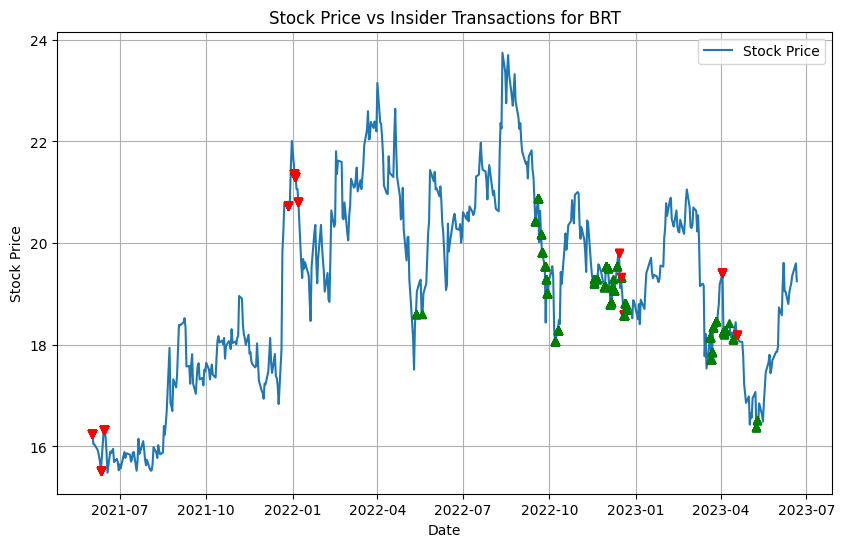

In [43]:
visualize_data("BRT")

###

LOG: Fetching price data for ASAN ...


LOG: Visualizing data for ASAN ...


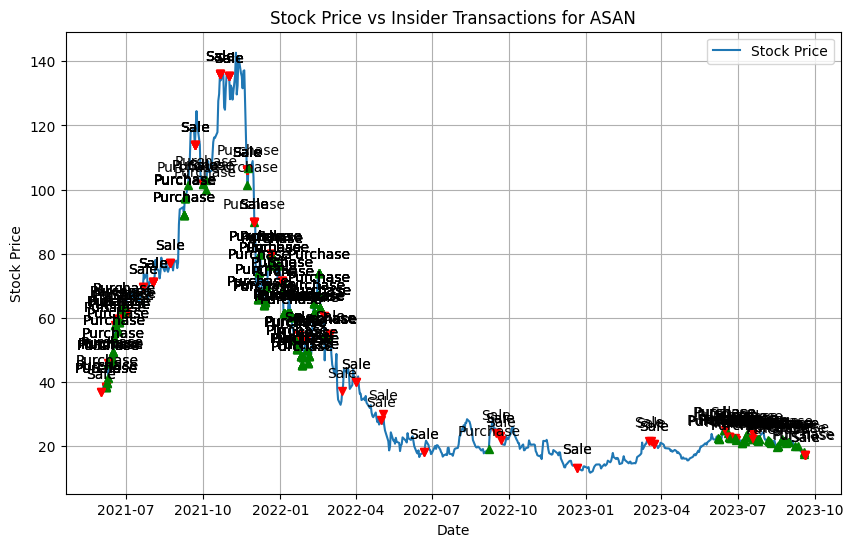

In [38]:
visualize_data("ASAN")

LOG: Fetching price data for HUBS ...


LOG: Visualizing data for HUBS ...


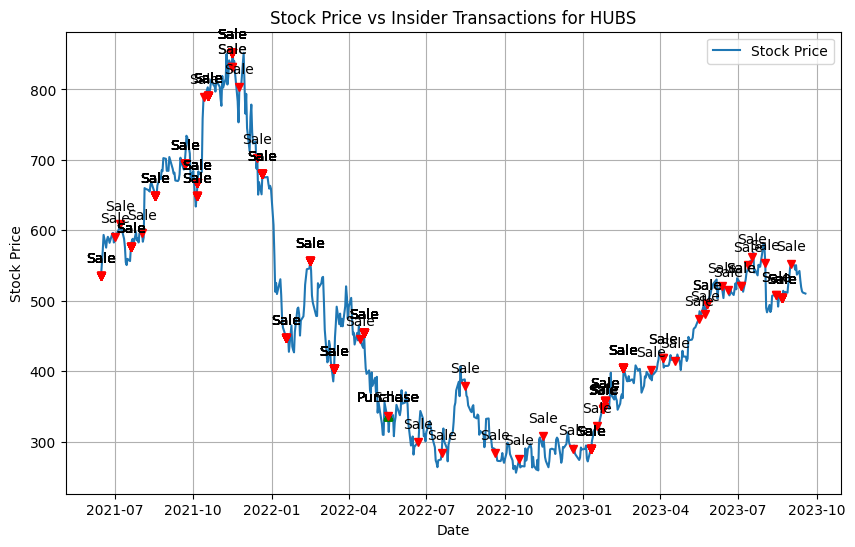

In [39]:
visualize_data("HUBS")

LOG: Fetching price data for AKAM ...


LOG: Visualizing data for AKAM ...


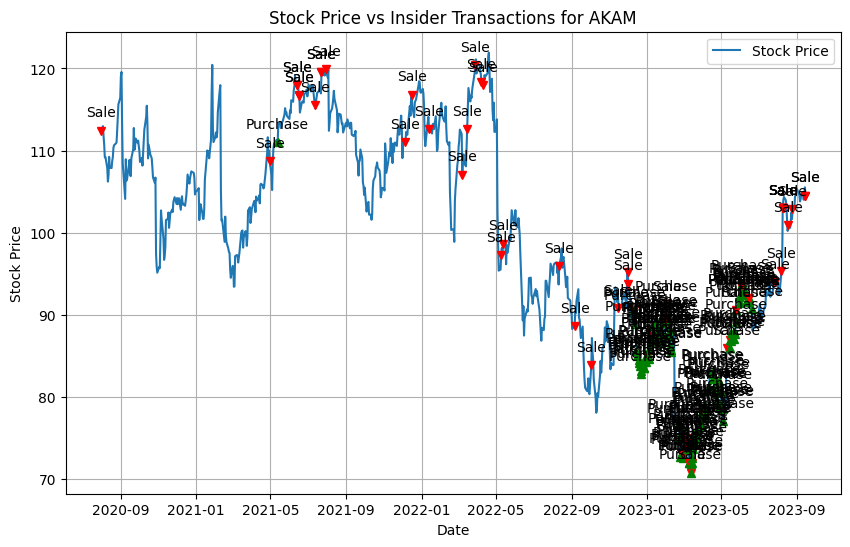

In [40]:
visualize_data("AKAM")

LOG: Fetching price data for DOCU ...


LOG: Visualizing data for DOCU ...


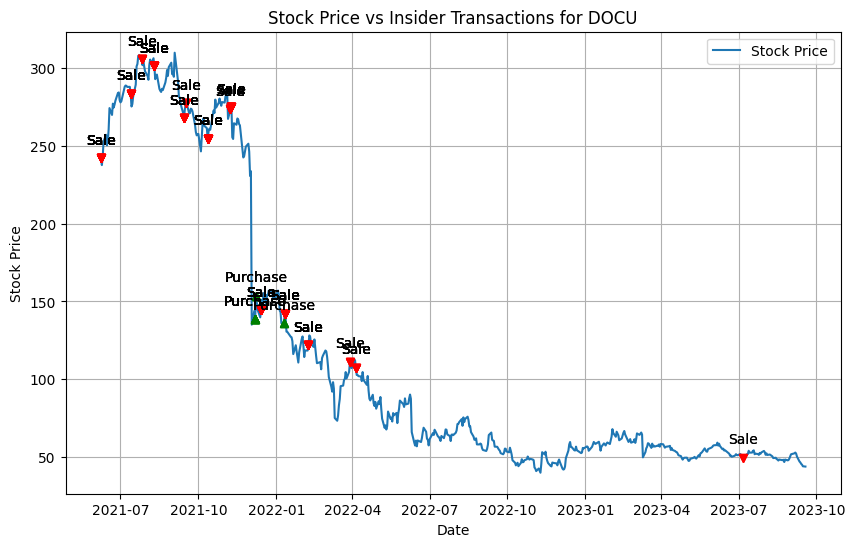

In [41]:
visualize_data("DOCU")